In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime

In [2]:
from env import Decode_v1

In [3]:
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(15,8)})

In [4]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

# create simple random weights (equal weight plus some noise 4% per annum)
data = np.tile( [1/factors_returns.shape[1]] * factors_returns.shape[1], 
               factors_returns.shape[0]).reshape(factors_returns.shape)
weights = pd.DataFrame(index=factors_returns.index, columns = factors_returns.columns, data=data)
weights += np.random.normal(0, 0.04/ np.sqrt(250), weights.shape)
print(strategy_returns)

            Last Price
Date                  
2010-01-04    0.000000
2010-01-05    0.002270
2010-01-06    0.004127
2010-01-07    0.000179
2010-01-08    0.001401
...                ...
2022-02-03   -0.002747
2022-02-04   -0.000319
2022-02-07    0.000347
2022-02-08    0.001770
2022-02-09    0.003407

[3058 rows x 1 columns]


In [5]:
def reward(weights, factors_returns, strategy_returns):
    '''
    The assumed formula is : 
    reward = [return by agent - "groundtruth" or financial strategy] + stability of the agent (?)
    '''
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values
        ) * np.sqrt(250) * np.sqrt(weights.shape[1]+1)
    #turn_over = 0.0020 * 365 * ((weights - weights.shift(1)).abs().fillna(0).values
    #    ) / ((weights.index[-1] -weights.index[0]).days) * np.sqrt(
    #    weights.shape[0] * (weights.shape[1]+1)) 
    #error_terms = np.concatenate([tracking_error, turn_over.flatten()], axis=0)
    #reward = -np.sqrt(np.mean(error_terms**2))
    reward = -np.sqrt(np.mean(tracking_error**2))
    return reward

In [6]:
print('reward {:.4}'.format(reward(weights, factors_returns, strategy_returns)))

reward -0.1521


In [7]:
weights.head()

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.090945,0.092317,0.090199,0.094067,0.094325,0.090569,0.089757,0.092375,0.093868,0.089770,0.087755
2010-01-05,0.090033,0.087429,0.093172,0.087554,0.089100,0.091208,0.092788,0.090543,0.092063,0.088791,0.089168
2010-01-06,0.089345,0.092671,0.087786,0.085906,0.094663,0.088542,0.095195,0.088989,0.090320,0.093394,0.093246
2010-01-07,0.088462,0.088496,0.088879,0.090313,0.083789,0.095360,0.093897,0.088275,0.088930,0.092194,0.091253
2010-01-08,0.092991,0.093696,0.094104,0.088239,0.091555,0.093624,0.095697,0.088398,0.090715,0.094380,0.094223


In [8]:
strategy_returns.head(10)

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.002270
2010-01-06,0.004127
2010-01-07,0.000179
2010-01-08,0.001401
2010-01-11,0.002056
2010-01-12,-0.001762
2010-01-13,-0.000401
2010-01-14,0.001357


In [9]:
def buildPrices(dataframe,base):
    df= pd.DataFrame()
    for name in dataframe.columns:
        df[name+' price']= base * (1 + dataframe[name]).cumprod()
    return df

In [10]:
df = buildPrices(factors_returns,100)

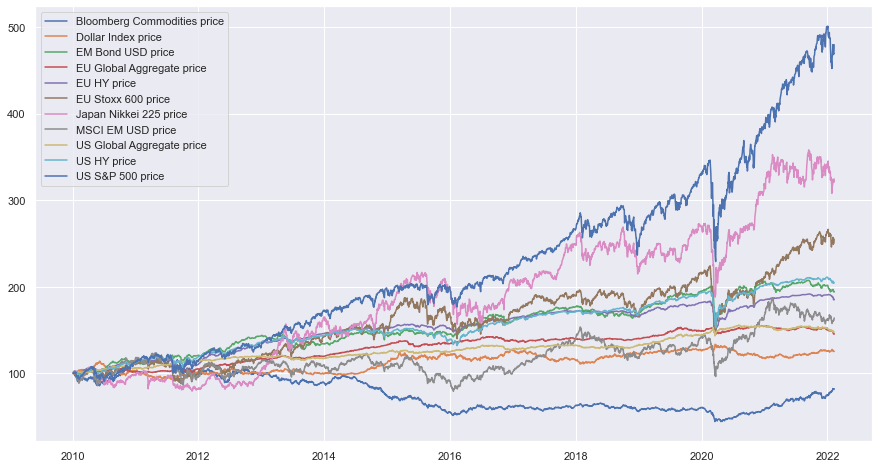

In [11]:
plt.plot(df)
plt.legend(df.columns,loc='upper left')

In [12]:
df['Strategy price']= 100 * (1 + strategy_returns['Last Price']).cumprod()

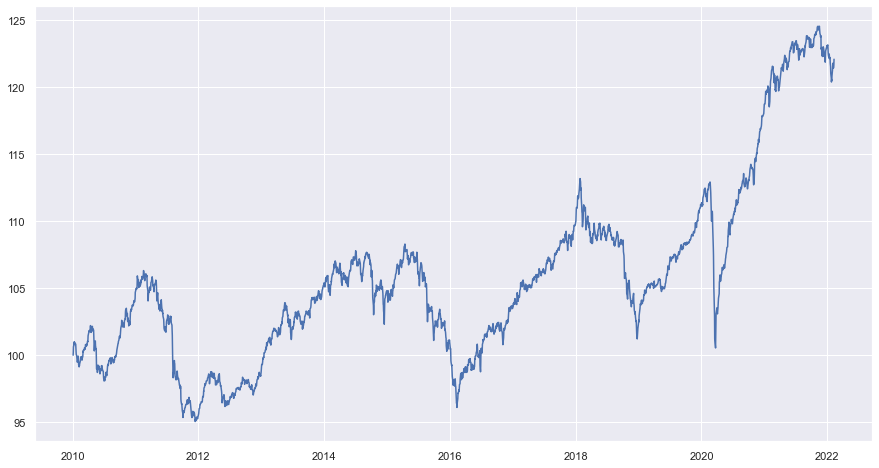

In [13]:
plt.plot(df['Strategy price'])

# Replaybuffer

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque
from itertools import count

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
print(device)

cuda


In [17]:
env = Decode_v1(factors_returns=factors_returns,strategy_returns=strategy_returns)

In [18]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Todo : Modifier le code du DQN pour les actions passées
https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=_BcDEjcABRVz

In [20]:
class DQN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        inp = F.relu(self.fc1(x))
        out = self.fc(inp)
        return out

In [21]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
#init_screen = get_screen()
#_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
#n_actions = env.action_space.n

num_classes  = len(weights.columns)
input_size  = num_classes
hidden_size = 64

policy_net = DQN(num_classes, input_size, hidden_size).to(device)
target_net = DQN(num_classes, input_size, hidden_size).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        #print('we enter')
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(state)
            #act = policy_net(state.float()).max(1)[1].view(1, 1) 
            act = policy_net(state.float())
            #print(act)
            return act
    else:
        #print('not entered')
        #return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
        vector = np.random.rand(1,num_classes)
        vector = (vector - np.min(vector)) / np.ptp(vector)
        return torch.tensor(vector[0], device=device)


episode_durations = []

In [22]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Todo : Créer une classe qui définit les états

In [23]:
factors_returns.head(5)

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,-0.001329,0.000467,0.004215,0.001062,0.007361,-0.000215,0.002538,0.010706,0.004409,0.002218,0.003119
2010-01-06,0.020527,0.000061,0.000460,-0.000679,0.006578,0.001435,0.004645,0.006396,-0.000904,0.007291,0.000850
2010-01-07,-0.015051,0.005292,-0.000300,0.001803,0.006402,0.000334,-0.004640,-0.007172,-0.000517,0.003488,0.004046
2010-01-08,-0.003042,-0.004810,0.000482,0.000787,0.004789,0.004298,0.010921,0.001963,0.000899,0.003684,0.002880


In [24]:
from env import Decode_v1
env = Decode_v1(factors_returns=factors_returns,strategy_returns=strategy_returns)

In [25]:
num_episodes = 5
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = torch.tensor(env.reset()).to(device)
    for t in count():
        # Select an action
        action = select_action(state)
        #  Perform action and observe new state
        last_state = state
        current_state, s_reward, done, _ = env.step(action)
        current_state = torch.tensor(current_state).to(device)
        # ICI UTILISER RENDER
        s_reward = torch.tensor([s_reward], device=device)
        print(current_state)

        if done:
            current_state = None

        # Store the transition in memory
        memory.push(last_state, action, current_state, s_reward)

        # Move to the next state
        state = current_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
#        if done:
#            episode_durations.append(t + 1)
#            plot_durations()
#            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
#plt.ioff()
#plt.show()

tensor([-0.0013,  0.0005,  0.0042,  0.0011,  0.0074, -0.0002,  0.0025,  0.0107,
         0.0044,  0.0022,  0.0031], device='cuda:0', dtype=torch.float64)
tensor([ 2.0527e-02,  6.0827e-05,  4.5993e-04, -6.7882e-04,  6.5783e-03,
         1.4351e-03,  4.6454e-03,  6.3964e-03, -9.0369e-04,  7.2905e-03,
         8.4952e-04], device='cuda:0', dtype=torch.float64)
tensor([-0.0151,  0.0053, -0.0003,  0.0018,  0.0064,  0.0003, -0.0046, -0.0072,
        -0.0005,  0.0035,  0.0040], device='cuda:0', dtype=torch.float64)
tensor([-0.0030, -0.0048,  0.0005,  0.0008,  0.0048,  0.0043,  0.0109,  0.0020,
         0.0009,  0.0037,  0.0029], device='cuda:0', dtype=torch.float64)
tensor([-0.0028, -0.0070,  0.0037,  0.0016,  0.0032, -0.0013,  0.0000,  0.0115,
         0.0004,  0.0013,  0.0017], device='cuda:0', dtype=torch.float64)
tensor([-1.9980e-02, -1.3867e-03,  1.4405e-03,  1.1292e-03, -8.4152e-05,
        -9.3549e-03,  7.4844e-03, -6.6959e-03,  3.9766e-03,  9.2808e-04,
        -9.3798e-03], device='cu

tensor([ 0.0053, -0.0010, -0.0014,  0.0023, -0.0003,  0.0130,  0.0007,  0.0001,
         0.0029,  0.0015, -0.0141], device='cuda:0', dtype=torch.float64)
tensor([-0.0135,  0.0011, -0.0055,  0.0007, -0.0069, -0.0297, -0.0054, -0.0306,
        -0.0004, -0.0058, -0.0051], device='cuda:0', dtype=torch.float64)
tensor([-0.0085, -0.0002, -0.0084,  0.0012, -0.0084, -0.0216, -0.0154, -0.0308,
         0.0028, -0.0102, -0.0389], device='cuda:0', dtype=torch.float64)
tensor([ 2.7644e-03, -1.2150e-02, -8.1338e-04,  1.5758e-05, -4.8484e-03,
        -4.8092e-03, -2.4502e-02,  4.8129e-03,  1.1602e-03, -4.4563e-03,
         1.5033e-02], device='cuda:0', dtype=torch.float64)
tensor([ 0.0062,  0.0075,  0.0032,  0.0003, -0.0004,  0.0046, -0.0027,  0.0059,
        -0.0018,  0.0008, -0.0129], device='cuda:0', dtype=torch.float64)
tensor([-0.0138,  0.0085, -0.0084,  0.0006, -0.0111, -0.0248, -0.0306, -0.0403,
         0.0010, -0.0071,  0.0004], device='cuda:0', dtype=torch.float64)
tensor([ 0.0159,  0.0014

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1408 and 11x64)

In [ ]:
def give_weights():
    weights_pred = []
    for i_episode in range(len(factors_returns)):
        state = torch.tensor(factors_returns.iloc[i_episode,:],device=device)
        for t in [0]:
            # Select and perform an action
            #print(state)
            action = select_action(state)
            weights_pred.append(action)
    return torch.stack(weights_pred)
    
    

In [ ]:
weights_tensor = give_weights()

In [ ]:
len(weights_tensor)

In [ ]:
len(data)

In [ ]:
weights_predicted = pd.DataFrame(index=factors_returns.index, columns = factors_returns.columns)

In [ ]:
weights_predicted.head()

In [ ]:
weights_predicted[:] = weights_tensor.cpu().numpy()

In [ ]:
weights_predicted.head()

In [ ]:
print('reward {:.4}'.format(reward(weights_predicted, factors_returns, strategy_returns)))

In [ ]:
pred_returns = pd.DataFrame()
pred_returns['Last Price'] = (1 + (weights_predicted * factors_returns).sum(axis=1)).cumprod().pct_change().fillna(0)

In [ ]:
pred_returns.head()

In [ ]:
df['Agent price']= 100 * (1 + pred_returns['Last Price']).cumprod()

In [ ]:
plt.plot(df[['Strategy price','Agent price']])
plt.legend(df[['Strategy price','Agent price']].columns,loc='upper left')